# Auxiliary notebook for PR 666: Beersheba - deconvolution city

This notebooks explains the procedure and most of the implemented functions in beersheba, a city which applies Lucy-Richardson deconvolution to SiPM images.

In [1]:
import pandas as pd
import numpy  as np

import invisible_cities.core.core_functions                   as     coref
import invisible_cities.io  .dst_io                           as     dstio

from invisible_cities.cities                 import beersheba as beerfun

from invisible_cities. reco.deconv_functions import deconvolve
from invisible_cities. reco.deconv_functions import deconvolution_input
from invisible_cities. reco.deconv_functions import InterpolationMethod

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 16
plt.rcParams["figure.max_open_warning"] = 100

In [3]:
# Input file and some event IDs to look at.
file = '/home/lior/NEXT/Software/data/Lucy/beersheba/paola_paper/hits/Tl208_NEW_v1_03_01_nexus_v5_03_04_UPPER_PORT_IC2610993_marija_pmaps_0.h5'
evts = [8, 9, 11]

# Parameters involved in beersheba city and the deconvolution.

deconv_params     = dict(
  q_cut           = 10,
  drop_dist       = [10., 10.],
  psf_fname       = '/home/lior/NEXT/Software/data/Lucy/Kr_MC/psf/V3_PSF_dst_sum_collapsed.h5',                                                                                   
  e_cut           = 0.008,
  n_iterations    = 30,
  n_iterations_g  = 30,
  iteration_tol   = 0.0000000001,
  sample_width    = [10., 10.],
  bin_size        = [ 1,  1],
  energy_type     = 'Ec',
  diffusion       = (1.072, 1.072, 0.3),
  deconv_mode     = 'joint',
  n_dim           = 2,
  cut_type        = 'abs',
  inter_method    = 'cubic')

deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.

cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

## City flow

##### Input SiPM signal.

SiPM signal which the city takes (esmeralda hits).

In [4]:
hdst = dstio.load_dst(file, 'RECO', 'Events')
evt  = evts[0]
hits = hdst[hdst.event == evt]

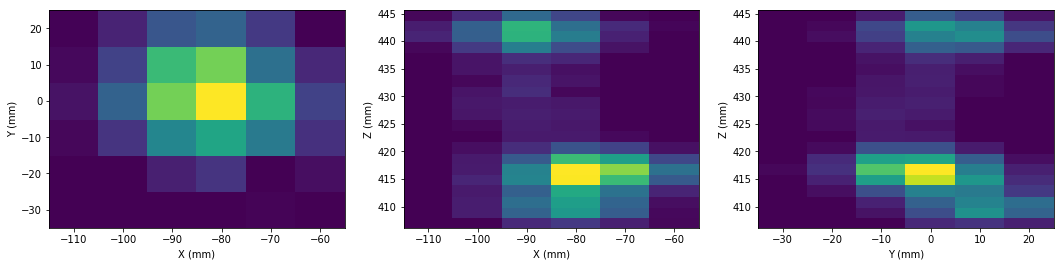

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + 10, 10)
yy = np.arange(hits.Y.min(), hits.Y.max() + 10, 10)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

##### Cut sensors

Cut sensors below a given threshold, this cleans the signal and removes hits considered not part of the image. It can be seen that the cut does not harm the image noticeably.

In [6]:
hits_cut = coref.timefunc(cut_sensors)(hits.copy())

Time spent in cut_over_Q: 0.0169830322265625 s


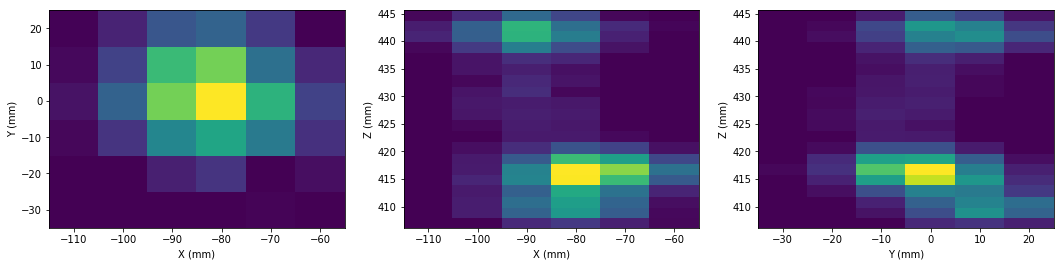

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + 10, 10)
yy = np.arange(hits.Y.min(), hits.Y.max() + 10, 10)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

Increased cut to see the impact of the function on higher thresholds:

In [8]:
cut_sensors_high = beerfun.cut_over_Q(40, ['E', 'Ec'])
hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())

Time spent in cut_over_Q: 0.02303290367126465 s


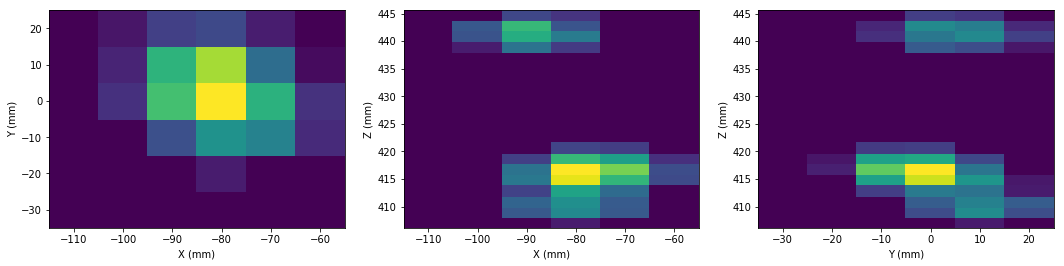

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + 10, 10)
yy = np.arange(hits.Y.min(), hits.Y.max() + 10, 10)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

When cutting, the energy is distributed through the reminding hits so the total energy of the event remains the same:

In [10]:
print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')

Energy (corrected) before cuts:    369901.393409729 (1.446286533056059)
Energy (corrected) after low cut:  369901.393409729 (1.446286533056059)
Energy (corrected) after high cut: 369901.393409729 (1.4462865330560586)


##### Drop isolated sensors

Cut sensors that are isolated in XY. Basically drops a sensor if there are no sensors near-by (distance can be configurable) that have seen light in the event.

In [11]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.01960301399230957 s


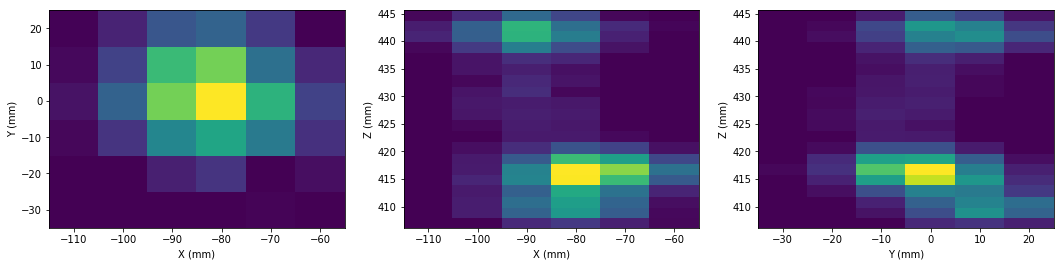

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + 10, 10)
yy = np.arange(hits.Y.min(), hits.Y.max() + 10, 10)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

It usually does not make a difference, as it's not usual to have rogue SiPMs. Let's add one and check the performance of the function:

In [13]:
hits_cut.loc[len(hits_cut)] = hits_cut.loc[0].values
hits_cut.loc[len(hits_cut)-1, ['X', 'Y', 'Q']] = [-250, -250, 1000]

In [14]:
hits_cut.tail()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id
276,8.0,0.0,0.0,-87.253126,-3.031466,1.0,-75.0,-5.0,0.0,0.0,443.710500,13.445358,559.597250,-1.0,0.002189,-1.0
277,8.0,0.0,0.0,-87.253126,-3.031466,1.0,-95.0,-5.0,0.0,0.0,445.570000,22.245390,2398.463123,-1.0,0.009501,-1.0
278,8.0,0.0,0.0,-87.253126,-3.031466,1.0,-95.0,5.0,0.0,0.0,445.570000,15.131508,1631.455494,-1.0,0.006450,-1.0
279,8.0,0.0,0.0,-87.253126,-3.031466,1.0,-85.0,-5.0,0.0,0.0,445.570000,12.796318,1379.678983,-1.0,0.005459,-1.0
280,8.0,0.0,0.0,-87.253126,-3.031466,1.0,-250.0,-250.0,0.0,0.0,406.159781,1000.000000,1245.697049,-1.0,0.004843,-1.0


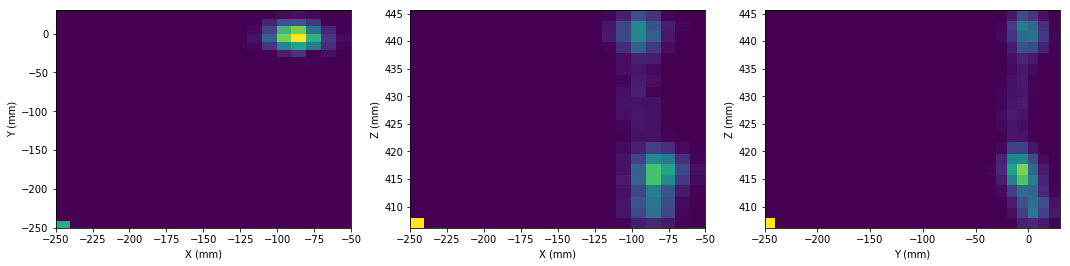

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits_cut.X.min(), hits_cut.X.max() + 10, 10)
yy = np.arange(hits_cut.Y.min(), hits_cut.Y.max() + 10, 10)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

And now after cut:

In [16]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.026757478713989258 s


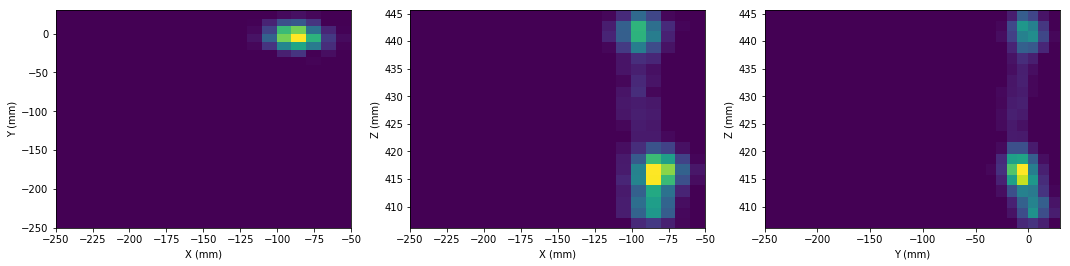

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits_cut.X.min(), hits_cut.X.max() + 10, 10)
yy = np.arange(hits_cut.Y.min(), hits_cut.Y.max() + 10, 10)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

When cutting, the energy is distributed through the reminding hits so the total energy of the event remains the same. The increment is due to the additional hit to `hits_copy` which caused an increase in the input energy. Still the energy before and after the cut remains the same as should be expected.

In [18]:
print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')

Energy (corrected) before cut: 371147.09045830765 (1.4511291612639798)
Energy (corrected) after  cut: 371147.09045830765 (1.4511291612639796)


Recover the hits as they should (normal cuts):

In [19]:
hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in cut_over_Q: 0.02704024314880371 s
Time spent in drop_isolated: 0.032816171646118164 s


##### Deconvolve signal
Last function in the city is `deconvolve_signal` which basically chooses the deconvolution mode (either 2D or 3D, and joint or separate, see code description) and calls deconvolve function (once per S2 peak). Which first interpolates the signal and then deconvolves it. After all the process, `deconvolve_signal` assigns the energy, measured by the PMTs (corrected or not, chosen by parameter) to each deconvolved hit based on their fraction of energy of the full S2 peak. 

Hereunder, `deconvolve_signal` output will be showed. Individual performance of each step will be looked into later in the notebook.

In [20]:
for iterN in np.arange(15, 91, 15):
    deconv_params_['n_iterations'] = iterN
    deconvolver = beerfun.deconvolve_signal(**deconv_params_)
    print(f'{iterN} iterations')
    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

15 iterations
Time spent in apply_deconvolution: 0.9039700031280518 s
30 iterations
Time spent in apply_deconvolution: 1.688899278640747 s
45 iterations
Time spent in apply_deconvolution: 2.1842472553253174 s
60 iterations
Time spent in apply_deconvolution: 3.178677797317505 s
75 iterations
Time spent in apply_deconvolution: 3.438901901245117 s
90 iterations
Time spent in apply_deconvolution: 4.936505079269409 s


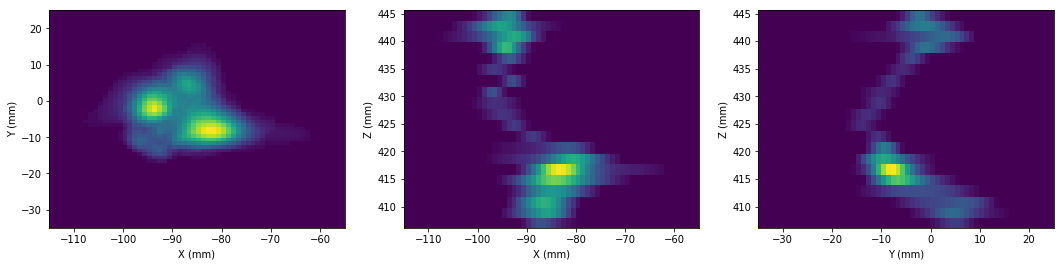

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + 1, 1)
yy = np.arange(hits.Y.min(), hits.Y.max() + 1, 1)
zz = hits.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

In [22]:
print(f'Corrected energy before deconvolution: {hits_drop.Ec.sum()}')
print(f'Corrected energy after  deconvolution: {hits_deco.E .sum()}')

Corrected energy before deconvolution: 1.446286533056059
Corrected energy after  deconvolution: 1.446286533056059


###### Joint vs separate mode

In joint mode, the PSF is based from the PSF files based on the Z of the slice/event and it has both diffusion and EL effects. In separate mode, two deconvolutions are done, one using the EL PSF and another using a model Gaussian starting on the result of the first (EL) deconvolution.

In [23]:
deconv_params_['deconv_mode' ] = 'joint'
deconv_params_['n_iterations'] = 90

deconvolver  = beerfun.deconvolve_signal(**deconv_params_)
print('Joint deconvolution')
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

deconv_params_['deconv_mode'] = 'separate'
deconv_params_['n_iterations_g'] = 90
deconvolver   = beerfun.deconvolve_signal(**deconv_params_)
print('Separate EL+gauss deconvolution')
hits_deco_sep = coref.timefunc(deconvolver)(hits_drop.copy())

Joint deconvolution
Time spent in apply_deconvolution: 4.348266124725342 s
Separate EL+gauss deconvolution
Time spent in apply_deconvolution: 7.51841926574707 s


Text(0.5, 0.98, 'Separate mode')

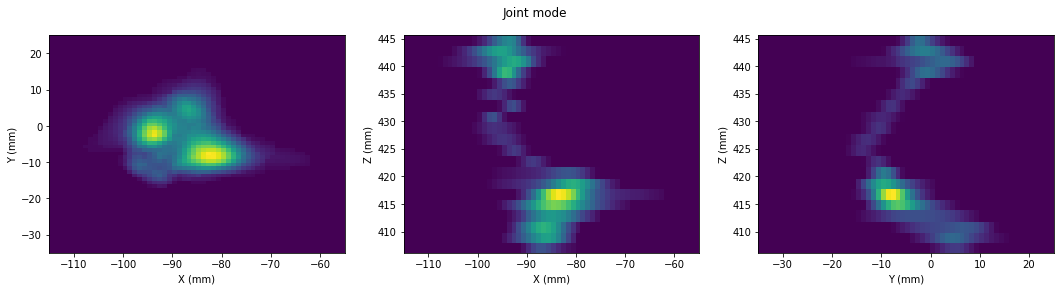

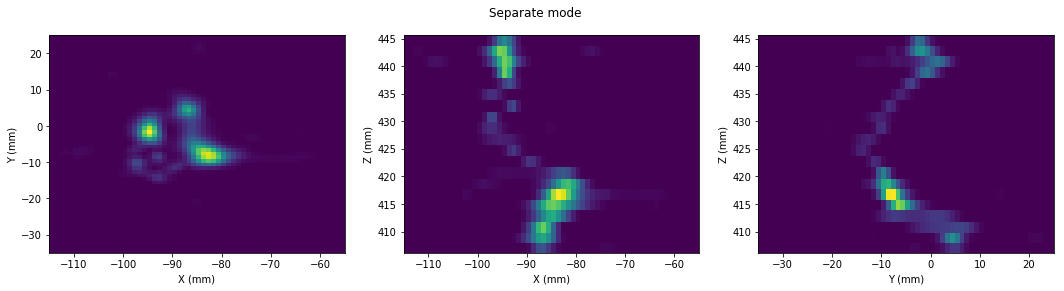

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + 1, 1)
yy = np.arange(hits.Y.min(), hits.Y.max() + 1, 1)
zz = hits.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Joint mode')

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + 1, 1)
yy = np.arange(hits.Y.min(), hits.Y.max() + 1, 1)
zz = hits.Z.unique()

axes[0].hist2d(hits_deco_sep.X, hits_deco_sep.Y, bins=[xx, yy], weights=hits_deco_sep.E);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco_sep.X, hits_deco_sep.Z, bins=[xx, zz], weights=hits_deco_sep.E);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco_sep.Y, hits_deco_sep.Z, bins=[yy, zz], weights=hits_deco_sep.E);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Separate mode')

## Inside `deconvolve_signal`

A bit more detailed look at each of the steps in the `deconvolve_signal` function: interpolation, deconvolution and energy assignment.

##### `deconvolve`

After choosing deconvolution modes, `deconvolve` function is called and handles the interpolation (`deconvolution_input` function) and the lucy-richardson deconvolution (`richardson_lucy`) given the position and Q of the events as well as the PSF that shall be used.

In [25]:
from invisible_cities. reco.deconv_functions import deconvolve
from invisible_cities. reco.deconv_functions import InterpolationMethod

In [26]:
deconvolver = deconvolve(90, 1e-10, [10., 10.], [1., 1.], InterpolationMethod.cubic)
psfs = dstio.load_dst(deconv_params['psf_fname'], 'PSF', 'PSFs')
psf  = psfs[psfs.z==412.5]

In [27]:
e = []
px, py, pz = [], [], []
for z in hits_drop.Z.unique():
    h = hits_drop[hits_drop.Z == z]
    value, pos = coref.timefunc(deconvolver)((h.X.values, h.Y.values), h.Q.values, psf)
    e.extend(value.flatten())
    px.extend(pos[0].flatten())
    py.extend(pos[1].flatten())
    pz.extend([z] * len(value.flatten()))

e = np.array(e).flatten()    
px = np.array(px).flatten()    
py = np.array(py).flatten()    
pz = np.array(pz).flatten() 

Time spent in deconvolve: 0.15325069427490234 s
Time spent in deconvolve: 0.18434667587280273 s
Time spent in deconvolve: 0.17828917503356934 s
Time spent in deconvolve: 0.1960599422454834 s
Time spent in deconvolve: 0.2080068588256836 s
Time spent in deconvolve: 0.18389105796813965 s
Time spent in deconvolve: 0.1844489574432373 s
Time spent in deconvolve: 0.1665189266204834 s
Time spent in deconvolve: 0.14133977890014648 s
Time spent in deconvolve: 0.14856672286987305 s
Time spent in deconvolve: 0.15241456031799316 s
Time spent in deconvolve: 0.14946889877319336 s
Time spent in deconvolve: 0.15143370628356934 s
Time spent in deconvolve: 0.14369750022888184 s
Time spent in deconvolve: 0.14631390571594238 s
Time spent in deconvolve: 0.14192724227905273 s
Time spent in deconvolve: 0.16918134689331055 s
Time spent in deconvolve: 0.1845541000366211 s
Time spent in deconvolve: 0.17184233665466309 s
Time spent in deconvolve: 0.1551048755645752 s
Time spent in deconvolve: 0.13146066665649414 

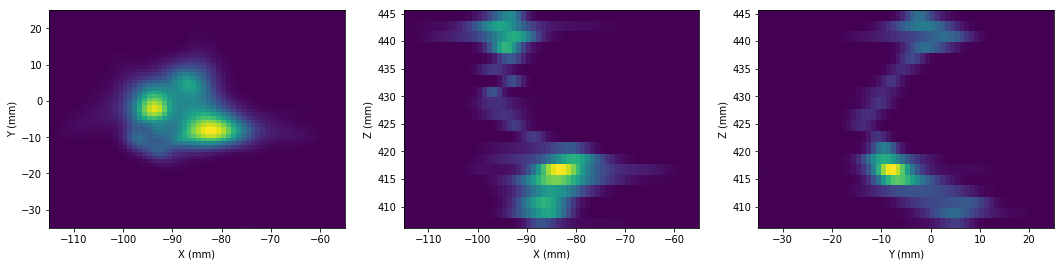

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist2d(px, py, bins=[xx, yy], weights=e);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(px, pz, bins=[xx, zz], weights=e);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(py, pz, bins=[yy, zz], weights=e);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

##### `create_deconvolution_df`

`create_deconvolution_df` applies a cut (absolute or relative) to the deconvolution output and creates a dataframe object from the deconvolution output. In the 2D mode, this is done slice by slice and then joined together.

In [29]:
deco = []
for z in hits_drop.Z.unique():
    h = hits_drop[hits_drop.Z == z]
    value, pos = deconvolver((h.X.values, h.Y.values), h.Q.values, psf)
    df = coref.timefunc(beerfun.create_deconvolution_df)(h, value.flatten(), pos, 
                                                         beerfun.CutType(deconv_params_['cut_type']), 
                                                         deconv_params_['e_cut'], 2)
    deco.append(df)
deco = pd.concat(deco)

Time spent in create_deconvolution_df: 0.008282899856567383 s
Time spent in create_deconvolution_df: 0.013116121292114258 s
Time spent in create_deconvolution_df: 0.012879133224487305 s
Time spent in create_deconvolution_df: 0.020967960357666016 s
Time spent in create_deconvolution_df: 0.015420198440551758 s
Time spent in create_deconvolution_df: 0.022855281829833984 s
Time spent in create_deconvolution_df: 0.018172264099121094 s
Time spent in create_deconvolution_df: 0.00957489013671875 s
Time spent in create_deconvolution_df: 0.006218910217285156 s
Time spent in create_deconvolution_df: 0.007247447967529297 s
Time spent in create_deconvolution_df: 0.008186578750610352 s
Time spent in create_deconvolution_df: 0.00727391242980957 s
Time spent in create_deconvolution_df: 0.006894350051879883 s
Time spent in create_deconvolution_df: 0.005807638168334961 s
Time spent in create_deconvolution_df: 0.0065572261810302734 s
Time spent in create_deconvolution_df: 0.006764888763427734 s
Time spen

Text(0.5, 0.98, 'Separate mode')

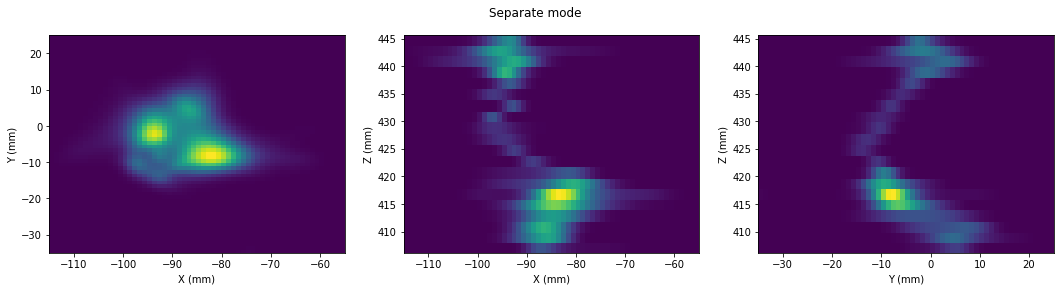

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + 1, 1)
yy = np.arange(hits.Y.min(), hits.Y.max() + 1, 1)
zz = hits.Z.unique()

axes[0].hist2d(deco.X, deco.Y, bins=[xx, yy], weights=deco.E);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(deco.X, deco.Z, bins=[xx, zz], weights=deco.E);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(deco.Y, deco.Z, bins=[yy, zz], weights=deco.E);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Separate mode')

In [31]:
print(f'min hit e before cut = {e.min()}')
print(f'min hit e after  cut = {deco.E.min()}')

min hit e before cut = 4.0580841047176597e-212
min hit e after  cut = 0.008006474714057434


In [32]:
deco.head()

,event,npeak,X,Y,Z,E
0,8,0,-95.5,6.5,406.159781,0.011910
1,8,0,-95.5,7.5,406.159781,0.017496
2,8,0,-95.5,8.5,406.159781,0.019151
3,8,0,-95.5,9.5,406.159781,0.015460
4,8,0,-95.5,10.5,406.159781,0.009105


##### `distribute_energy`

`distribute_energy` assigns the total S2 energy measured by PMTs to the deconvolved dataframe.

In [33]:
from invisible_cities. evm.event_model       import HitEnergy

In [34]:
print(f'Energy before assignment = {deco.E.sum()}')
coref.timefunc(beerfun.distribute_energy)(deco, hits_drop, HitEnergy.Ec)
print(f'Energy after assignment = {deco.E.sum()}')
print(f'Energy according to hits= {hits_drop.Ec.sum()}')

Energy before assignment = 1333348.829163752
Time spent in distribute_energy: 0.002636432647705078 s
Energy after assignment = 1.446286533056059
Energy according to hits= 1.446286533056059


### Inside `deconvolve`

##### `deconvolution_input`

`deconvolution_input` prepares the input before deconvolution. First it adds 0s around the event (at the distance at which SiPM should be) to not have edge misbehaviours in the interpolation process. If interpolation is desired then `interpolate_signal` is called. The latest function interpolates the input using `interpolate.griddata` from scipy.

In [35]:
from invisible_cities. reco.deconv_functions import deconvolution_input

In [36]:
n_dim=2

interpolator = deconvolution_input(deconv_params_['sample_width'][:n_dim], deconv_params_['bin_size'][:n_dim], InterpolationMethod.cubic)

In [37]:
e = []
px, py, pz = [], [], []
for z in hits_drop.Z.unique():
    h = hits_drop[hits_drop.Z == z]
    value, pos = coref.timefunc(interpolator)((h.X.values, h.Y.values), h.Q.values)
    e.extend(value.flatten())
    px.extend(pos[0].flatten())
    py.extend(pos[1].flatten())
    pz.extend([z] * len(value.flatten()))

e = np.array(e).flatten()    
px = np.array(px).flatten()    
py = np.array(py).flatten()    
pz = np.array(pz).flatten()    


Time spent in deconvolution_input: 0.0029418468475341797 s
Time spent in deconvolution_input: 0.0026504993438720703 s
Time spent in deconvolution_input: 0.002938985824584961 s
Time spent in deconvolution_input: 0.004019498825073242 s
Time spent in deconvolution_input: 0.0047533512115478516 s
Time spent in deconvolution_input: 0.0038177967071533203 s
Time spent in deconvolution_input: 0.0032732486724853516 s
Time spent in deconvolution_input: 0.0033893585205078125 s
Time spent in deconvolution_input: 0.0019366741180419922 s
Time spent in deconvolution_input: 0.0020592212677001953 s
Time spent in deconvolution_input: 0.002176046371459961 s
Time spent in deconvolution_input: 0.002218484878540039 s
Time spent in deconvolution_input: 0.002356290817260742 s
Time spent in deconvolution_input: 0.0019524097442626953 s
Time spent in deconvolution_input: 0.002125978469848633 s
Time spent in deconvolution_input: 0.0022928714752197266 s
Time spent in deconvolution_input: 0.002780914306640625 s
Time

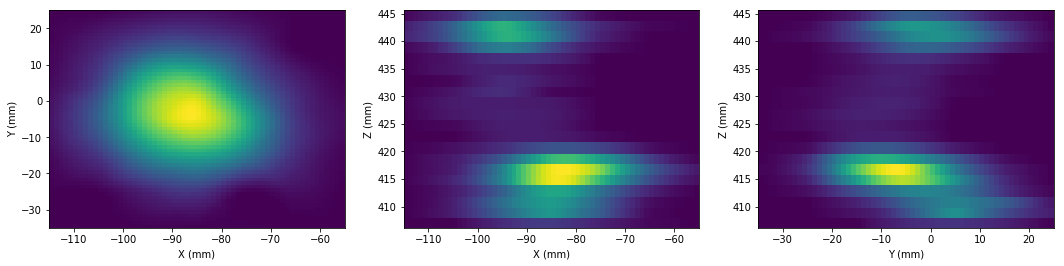

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist2d(px, py, bins=[xx, yy], weights=e);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(px, pz, bins=[xx, zz], weights=e);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(py, pz, bins=[yy, zz], weights=e);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

##### `richardson_lucy`

`richardson_lucy` applies Lucy-Richardson deconvolution. The function is a modified version (to avoid divergence when 0s appear and to add compability for 3D PSFs) of the richardson_lucy function in skimage.

In [39]:
from invisible_cities. reco.deconv_functions import richardson_lucy

In [40]:
e = []
px, py, pz = [], [], []
psf2 = psf.factor.values.reshape(psf.loc[:, ['xr', 'yr']].nunique().values)
for z in hits_drop.Z.unique():
    h = hits_drop[hits_drop.Z == z]
    value, pos = interpolator((h.X.values, h.Y.values), h.Q.values)
    value = coref.timefunc(richardson_lucy)(value, psf2, 90, 1e-10)
    e.extend(value.flatten())
    px.extend(pos[0].flatten())
    py.extend(pos[1].flatten())
    pz.extend([z] * len(value.flatten()))

e = np.array(e).flatten()    
px = np.array(px).flatten()    
py = np.array(py).flatten()    
pz = np.array(pz).flatten()

Time spent in richardson_lucy: 0.1442568302154541 s
Time spent in richardson_lucy: 0.17611289024353027 s
Time spent in richardson_lucy: 0.17767071723937988 s
Time spent in richardson_lucy: 0.17766141891479492 s
Time spent in richardson_lucy: 0.19912290573120117 s
Time spent in richardson_lucy: 0.18128418922424316 s
Time spent in richardson_lucy: 0.19313406944274902 s
Time spent in richardson_lucy: 0.16232085227966309 s
Time spent in richardson_lucy: 0.14285659790039062 s
Time spent in richardson_lucy: 0.14353299140930176 s
Time spent in richardson_lucy: 0.15779876708984375 s
Time spent in richardson_lucy: 0.15044569969177246 s
Time spent in richardson_lucy: 0.1488332748413086 s
Time spent in richardson_lucy: 0.14297246932983398 s
Time spent in richardson_lucy: 0.14405250549316406 s
Time spent in richardson_lucy: 0.14037513732910156 s
Time spent in richardson_lucy: 0.17055439949035645 s
Time spent in richardson_lucy: 0.17955994606018066 s
Time spent in richardson_lucy: 0.179257392883300

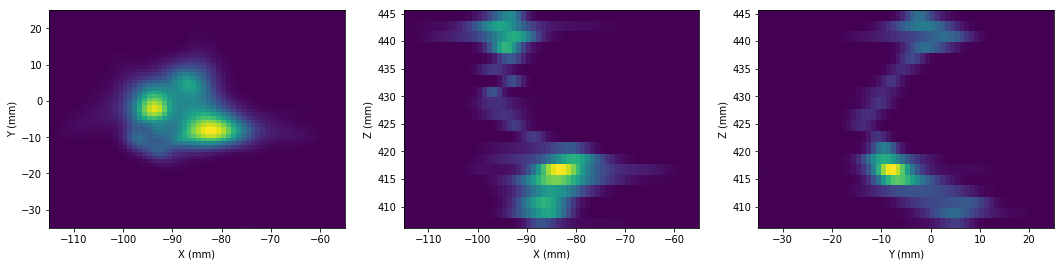

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist2d(px, py, bins=[xx, yy], weights=e);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(px, pz, bins=[xx, zz], weights=e);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(py, pz, bins=[yy, zz], weights=e);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

## Profiles

Profile running over 100 events in simulated data.

#### CPU profile (cProfile)

![title](cpu_prof.png)

#### Memory profile (mprof)

![title](memprof.png)
